In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MaxAbsScaler
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import explained_variance_score, confusion_matrix


# Loading data
cpi = pd.read_csv(
    "cpi_data_formatted.csv", 
    infer_datetime_format=True,
    parse_dates=True
)


# Loading data
#cpi_file = r'CPI Data - Sheet1.csv'
#cpi = pd.read_csv(cpi_file)

# Convert 'DATE' to datetime
cpi['DATE'] = pd.to_datetime(cpi['DATE'], errors='coerce')

# Extract timestamp as a numerical representation of the date
#cpi['Timestamp'] = (cpi['DATE'] - pd.Timestamp("1960-01-01")) // pd.Timedelta('1D')
# Convert date to a float representation (e.g., YYYYMMDD)
#cpi['date_as_float'] = cpi['DATE'].apply(lambda x: float(x.strftime('%Y%m%d')) if pd.notnull(x) else x)

# Get dummies and encode 'President' columns as 0 and 1
df_encoded = pd.get_dummies(cpi, columns=['President'])
df_encoded = df_encoded.set_index("DATE")
# Convert boolean values to integers (0 and 1)
df_encoded[['President_Dem', 'President_Rep']] = df_encoded[['President_Democrat', 'President_Republican']].astype(int)

# Drop the original 'President' columns
#df_encoded = df_encoded.drop(['President_Democrat', 'President_Republican', 'DATE'], axis=1)
df_encoded = df_encoded.drop(['President_Democrat', 'President_Republican'], axis=1)

C:\Users\tlsul\AppData\Local\Temp\ipykernel_8340\2955611224.py:19: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  cpi = pd.read_csv(


In [2]:
df_encoded

,Crude,natural_gas,Cocoa,Coffee,Soybeans,soybean_oil,soybean_meal,Maize,Wheat,Banana,...,Cotton,Rubber,Phosphate,Aluminum,Iron ore,Copper,Gold,CPI,President_Dem,President_Rep
DATE,,,,,,,,,,,,,,,,,,,,,
1960-01-01,1.63,0.14,0.63,0.94,94.00,204.00,91.90,45.00,59.89,0.14,...,0.65,0.82,13.00,511.47,11.42,715.40,35.27,29.370,0,1
1960-02-01,1.63,0.14,0.61,0.95,91.00,201.00,86.70,44.00,60.99,0.14,...,0.65,0.83,13.00,511.47,11.42,728.19,35.27,29.410,0,1
1960-03-01,1.63,0.14,0.58,0.93,92.00,201.00,84.10,45.00,61.73,0.14,...,0.65,0.86,13.00,511.47,11.42,684.94,35.27,29.410,0,1
1960-04-01,1.63,0.14,0.60,0.93,93.00,207.00,86.70,45.00,60.99,0.14,...,0.64,0.86,13.00,511.47,11.42,723.11,35.27,29.540,0,1
1960-05-01,1.63,0.14,0.60,0.92,93.00,209.00,81.50,48.00,57.69,0.15,...,0.65,0.93,13.00,511.47,11.42,684.75,35.27,29.570,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01,78.98,2.55,3.39,4.27,633.85,1135.74,517.23,242.38,345.50,1.55,...,2.05,1.49,342.50,2159.73,114.43,8476.68,1951.02,304.348,1,0
2023-08-01,84.72,2.58,3.46,4.12,583.93,1126.53,514.56,207.61,315.82,1.56,...,2.11,1.47,346.25,2136.57,110.20,8349.13,1918.70,306.269,1,0
2023-09-01,92.22,2.64,3.61,4.05,619.04,1111.63,509.31,223.81,314.68,1.56,...,2.16,1.55,347.50,2184.67,120.98,8276.71,1915.95,307.481,1,0


In [3]:
features = df_encoded[[
     'Crude', 'natural_gas', 'Cocoa', 'Coffee', 'Soybeans', 'soybean_oil',
    'soybean_meal', 'Maize', 'Wheat', 'Banana', 'Orange', 'Beef', 'Chicken',
    'Sugar', 'Cotton', 'Rubber', 'Phosphate', 'Aluminum', 'Iron ore', 'Copper',
    'Gold', 'President_Dem','President_Rep']]
#.astype(float)

target_variable = df_encoded['CPI']

In [130]:
# Import required libraries
from pandas.tseries.offsets import DateOffset

# Select the start of the training period
training_begin = features.index.min()

# Display the training begin date
print(training_begin)

# Select the ending period for the training data with an offset of 18 months
training_end = features.index.min() + DateOffset(months=360)

# Display the training end date
print(training_end)

# Generate the X_train and y_train DataFrames
X_train = features.loc[training_begin:training_end]
y_train = target_variable.loc[training_begin:training_end]

# Generate the X_test and y_test DataFrames
X_test = features.loc[training_end:]
y_test = target_variable.loc[training_end:]

1960-01-01 00:00:00
1990-01-01 00:00:00


In [152]:
#target = target_variable

#training_features, testing_features, training_target, testing_target = \
            #train_test_split(features, target, random_state=42)

# Average CV score on the training set was: -3.7106600813535024
exported_pipeline = make_pipeline(
    MaxAbsScaler(),
    StackingEstimator(estimator=RidgeCV()),
    ExtraTreesRegressor(bootstrap=False, max_features=0.7500000000000001, min_samples_leaf=2, min_samples_split=3, n_estimators=100)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(X_train, y_train)

results = exported_pipeline.predict(X_test)


In [153]:
# Evaluate the model on the test set
test_score = exported_pipeline.score(X_test, y_test)
print(f'Test Score: {test_score}')

Test Score: -5.3284508647251725


In [154]:
need_dates_for_results = pd.DataFrame(index=X_test.index)
need_dates_for_results['cpi_prediction'] = results

#need_dates_for_results

predictions_df = need_dates_for_results


predictions_df["cpi_actual"] = y_test

# Review the DataFrame
predictions_df

,cpi_prediction,cpi_actual
DATE,,
1990-01-01,126.316333,127.500
1990-02-01,124.479000,128.000
1990-03-01,124.012833,128.600
1990-04-01,122.989333,128.900
1990-05-01,121.936000,129.100
...,...,...
2023-07-01,91.799000,304.348
2023-08-01,91.799000,306.269
2023-09-01,91.827000,307.481


In [155]:
#y_test = actual
#results = prediction



In [156]:
predictions_df["cpi_actual"] = y_test

# Review the DataFrame
predictions_df

,cpi_prediction,cpi_actual
DATE,,
1990-01-01,126.316333,127.500
1990-02-01,124.479000,128.000
1990-03-01,124.012833,128.600
1990-04-01,122.989333,128.900
1990-05-01,121.936000,129.100
...,...,...
2023-07-01,91.799000,304.348
2023-08-01,91.799000,306.269
2023-09-01,91.827000,307.481


<Axes: title={'center': 'CPI Actual vs Predicted Extra Tree Regressor'}, xlabel='DATE', ylabel='CPI in bps'>

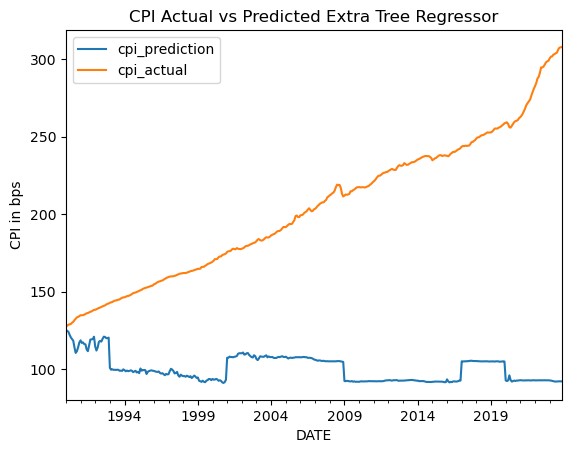

In [147]:
predictions_df.plot(title = 'CPI Actual vs Predicted Extra Tree Regressor', ylabel = 'CPI in bps' )

In [148]:
# Assuming you have trained your model and have predictions
y_true = y_test  # True target values
y_pred = results  # Predicted values from the model

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
evs = explained_variance_score(y_true, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)
print("Explained Variance Score:", evs)


Mean Squared Error: 13227.409607377205
Mean Absolute Error: 103.42417691977691
R-squared: -5.345563719152354
Explained Variance Score: -0.21412019180676234
